# INFO 3350/6350

## Lecture 18: Document similarity using document embeddings

## To do

* Week 13: Read Thai et al
  * Response is optional (for all)
* PS5 in flight
  * Due Thursday, 11/30 (the week after Thanksgiving), at 11:59pm
* Final exam/project to be released by Thanksgiving
  * Due Saturday, December 9, at **noon** per Registrar

## Document similarity using document embeddings

The goal of this lecture is to learn how to use document embeddings in order to explore which texts in a dataset are similar to each other.

This is a follow-up to lecture 15 on word similarity. There, we saw how to use contextual word embeddings to compare meanings of individual words in poems. Here, we will explore what we can do when we are able to represent whole documents using embeddings.

We'll answer two questions:
1. How can we use document embeddings to understand the differences between two categories? As an example, what can we learn about the differences between narrative and non-narrative text?
2. Given a specific document, what are similar documents?

### What's a document embedding?

A **word embedding** represents a word as a vector (i.e. a list of numbers) that can then be compared to other word embeddings. We can use the same idea for documents: a **document embedding** represents an entire document as a vector. Document embeddings can then be compared to each other, just like word embeddings can.

### Models to use for document embeddings

We'll use [Sentence-T5](https://huggingface.co/sentence-transformers/sentence-t5-base) (ST5), an encoder-only variant of the T5 encoder-decoder model that was specifically trained for comparing documents. ST5 works on documents up to 512 tokens long--if a text is longer than this, it will be truncated. This is enough for the datasets in this tutorial, but keep this in mind when working with other datasets.

While this is a starting point, other document embeddings can be a good choice, too, depending on the task. Other options include [General Text Embeddings](https://huggingface.co/thenlper/gte-base) and can be found on Hugging Face's [sentence-transformers](https://huggingface.co/docs/hub/sentence-transformers) package. This is an active area of research, with new models being trained regularly as of late 2023.


## Setup: install and import pacakges

### Setup: choose a runtime with a GPU

### Setup: install and import packages

In [1]:
# Install packages that we need
!pip install sentencepiece
!pip install transformers
!pip install sentence-transformers
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=833e5d2a324ce32c65dd7328d1ff354a1d21f389944a6ff09fdb2381c80fe61a
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 3.0 MB/s 

In [2]:
# Import packages

# For downloading data
import gdown
# For working with JSON files
import json
# For working with LMs
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import numpy as np
import pandas as pd
import operator
# For printing long documents
import textwrap
# For status bars
from tqdm.notebook import tqdm
# For dimensionality reduction
import umap.umap_ as umap
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns


## Setup: initialize the ST5 model

In [3]:
# Initialize ST5 model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/sentence-t5-base')

## Understanding categories with a dataset of narrative

The article [Towards a Data-Driven Theory of Narrativity](https://muse.jhu.edu/pub/1/article/898332/summary) by Andrew Piper and Sunyam Bagga offers a definition of narrative: "Somebody tells someone that someone did something(s) [to someone] somewhere at some time for some reason." Some text contains narrative. Other text, such as scientific papers, does not usually contain narrative. We're going to use document embeddings and similarity to explore this categorization.

**Questions:**

1. How distinct are the categories of narrative and non-narrative text?

2. Given a specific *narrative* text, what do similar documents look like? Given a specific *non-narrative* text, what do similar documents look like?

**Dataset**: We are going to use a dataset of texts that are labeled as either narrative or non-narrative. The [original data](https://doi.org/10.6084/m9.figshare.21656780.v1) accompanied the article "Towards a Data-Driven Theory of Narrativity" by Andrew Piper and Sunyam Bagga in New Literary History, 2023. The code below loads a subset of the original dataset.

**Process**:
Our general strategy first assesses the categories qualitatively and then compares embeddings quantitatively:
1. Load dataset
2. Get document embeddings
3. Visualize document embeddings using dimensionality reduction
4. Use the visualization to identify promising examples to examine more closely
5. For specific examples, use embedding similarity to explore similar documents.

### Download prepared narrativity data

The data is stored as a CSV file with two columns: the first column is the label (either `narrative` or `non-narrative`), and the second column contains the text.

In [4]:
# First download the file to the Colab runtime
url = 'https://drive.google.com/uc?id=1gmVTLcfdzjjpr9P0x7OPjoS1hpu76t0-'
filename = 'narrativity.csv'
gdown.download(url, filename, quiet=True)
# Load the data
narrativity_df = pd.read_csv(filename)
# Store the data in lists
narrativity_texts = narrativity_df['text'].tolist()
narrativity_labels = narrativity_df['label'].tolist()

We can view the first several texts and their labels:

In [5]:
narrativity_df.sample(3)

,label,text
4,non-narrative,"Petitioner makes contentions, with respect to ..."
91,narrative,"A HUNTSMAN, returning with his dogs from the f..."
7,non-narrative,To have a mind is not to have a movie theater ...


In [6]:
print("Narrativity data shape:", narrativity_df.shape)

Narrativity data shape: (100, 2)


### Create document embeddings and visualize them with dimensionality reduction

Now that we've downloaded the data, we can construct 768-dimensional document embeddings using ST5. To visualize the similarities between these embeddings, we use UMAP, though PCA might be a viable alternative.

In [7]:
%%time
# Create the document embeddings by running the texts through ST5
narrativity_embeddings = model.encode(narrativity_texts)

CPU times: user 2.89 s, sys: 1.03 s, total: 3.92 s
Wall time: 15 s


In [8]:
# Reduce the embeddings to two dimensions for visualization
reducer = umap.UMAP()
narrativity_umap_embeddings = reducer.fit_transform(narrativity_embeddings)

In [9]:
# This function takes in two-dimensional embeddings and labels
# and draws a scatterplot. Each document's point is colored by its label.
# It also annotates each point with the document's id number
def plot_umap_embeddings(umap_embeddings, labels, annotate_idxs=True):
  df_to_plot = pd.DataFrame({'x': umap_embeddings[:, 0],
                            'y': umap_embeddings[:, 1],
                            'label': labels})
  label_names = list(set(labels))
  label_to_color = {label_names[0]: '#fc8d62',
                    label_names[1]: '#8da0cb'}
  sns.scatterplot(data=df_to_plot, x='x', y='y', hue='label', palette=label_to_color)
  plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
  # Get rid of the axes units and labels
  # The units are not very meaningful when using UMAP
  axis = plt.gca()
  axis.set_xlabel('')
  axis.set_ylabel('')
  axis.set_xticks([])
  axis.set_yticks([])
  if annotate_idxs:
    for idx in range(umap_embeddings.shape[0]):
      plt.annotate(idx, umap_embeddings[idx, :], xytext=umap_embeddings[idx, :]+0.02, fontsize=6, color='k', alpha=0.8)

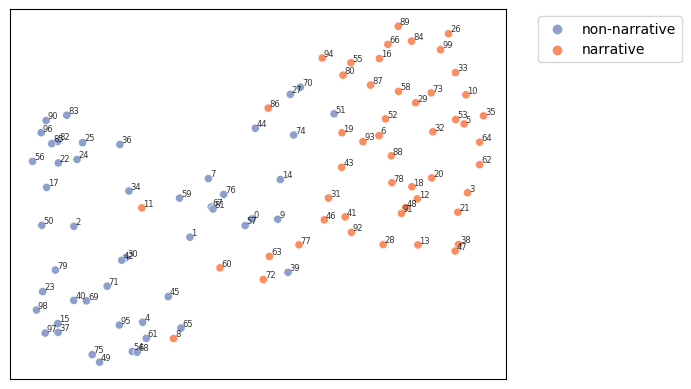

In [10]:
# Now plot the embeddings
plot_umap_embeddings(narrativity_umap_embeddings, narrativity_labels)

We can very clearly see that the classes cluster together&mdash;narrative texts (represented as blue dots) are generally on one side of the image and non-narrative texts (orange dots) are on the other. The embeddings capture differences between narrative and non-narrative texts.

Let's look at individual texts now. Each dot is annotated with its index in small gray text. We can see that there are some outlier documents. For example, document 11 is categorized as narrative, but it is surrounded by non-narrative text. What text does this document contain? What do the most-similar documents to it look like?

The following function uses the cosine similarity of the document embeddings to rank all the other embeddings by similarity and print out the three documents that are most similar. (Note that ST5 embeddings are L2-normalized, i.e., their Euclidean length is one, so taking the dot product of any two of them returnms their cosine similarity.)

In [11]:
# Print out a document and its three closest neighbors
def print_neighbors(text_idx):
  print(f'Query text: {narrativity_labels[text_idx]}')
  print(textwrap.fill(narrativity_texts[text_idx][:512]))
  print()
  # The text embedding is the row in the embeddings matrix
  # with the same id as the document
  this_embedding = narrativity_embeddings[text_idx, :]
  # Get similarities by taking the dot product between the embeddings matrix
  # and the embedding we care about
  cosine_similarities = np.dot(narrativity_embeddings, this_embedding)
  # Sort the similarities in descending order
  ordered_idxs = np.argsort(cosine_similarities)[::-1]
  # Cosine similarity with itself is always near 1
  assert(ordered_idxs[0] == text_idx)
  for num, idx in enumerate(ordered_idxs[1:4]):
    print(f'Nearest neighbor {num}: {narrativity_labels[idx]}, {cosine_similarities[idx]:.4f} cosine similarity')
    print(textwrap.fill(narrativity_texts[idx][:512]))
    print()


In [12]:
# Print the most similar documents to document 11
print_neighbors(text_idx=11)

Query text: narrative
Fresher, richer, more data-driven, they are the quants of the
philanthropic world. They want to improve entire sectors such as
education and create institutions where none existed, and they want to
do everything in a precisely measurable way. The Credit Suisse poll,
which was skewed to the high-tech sector, found that 44 percent of
them wanted to affect change within ten years—a far cry from the days
of Carnegie and Rockefeller, whose largess is still being felt. (Only
15 percent thought of their philanthro

Nearest neighbor 0: non-narrative, 0.8592 cosine similarity
While digital technologies were initially seen as harbingers of
globalisation and cosmopolitanism, scholars increasingly acknowledge
their role in the rise of nationalism and right-wing populism. Yet
this surge of interest leaves at least two important questions
unanswered. Where was nationalism before its apparent resurgence? Are
contemporary forms of nationalism different from their predecessors,
an

Document 11 is a narrative about "the quants of the
philanthropic world". The three most similar documents are all categorized as non-narrative. Perhaps the subject matter of this document is what makes it more similar to these non-narrative texts.

On the other hand, document 39 is a non-narrative text that appears next to many narrative texts in the visualization. Let's examine it and its nearest neighbors:

In [13]:
print_neighbors(text_idx=39)

Query text: non-narrative
According to the rumour of the time, Burke sold two of his pensions
upon lives for L27,000, and there was left the third pension of L1200.
By and by, when the resentment of the Opposition was roused to the
highest pitch by the infamous Treason and Sedition Bills of 1795, the
Duke of Bedford and Lord Lauderdale, seeking to accumulate every
possible complaint against the Government, assailed the grant to
Burke, as made without the consent of Parliament, and as a violent
contradiction to the whole policy of th

Nearest neighbor 0: narrative, 0.8872 cosine similarity
Once, in November 1476, Duke Francis temporarily succumbed to Edward
IV’s offers of funds and military aid in exchange for the nineteen-
year-old Henry’s extradition. But at the port of St Malo, Henry gave
his English guard the slip, feigning illness and dodging into
sanctuary. When he made it back to the Breton court, Francis was all
contrition.7  In England, meanwhile, the uncertainty of the 1460s h

We can also look at examples that are solidly narrative and solidly non-narrative. The following text is non-narrative, and it is very similar to other non-narrative texts, as we can see:

In [14]:
print_neighbors(text_idx=37)

Query text: non-narrative
Accordingly, the Corporation and the Agents hereby agree that offers
and sales of the Offered Shares in the United States shall be made
only to "accredited investors" within the meaning of Rule 501(a) of
Regulation D under the U.S. Securities Act in the manner specified in
Schedule A hereto, which terms and conditions are hereby incorporated
by reference in and shall form a part of this Agreement. Any agreement
between an Agent and the members of any sub-agent group or selling
group formed in connection wit

Nearest neighbor 0: non-narrative, 0.9133 cosine similarity
WHEREAS, it is integral to Buyer's acquisition of the Company Business
and a condition precedent to the closing of the transactions
contemplated by the Purchase Agreement that the Sellers enter into
this Agreement with Buyer to provide for the protection of the
Combined Business's customer and vendor relationships, trade secrets,
confidential information and other business operations. Pursuant to


Document 53 is a narrative text that is surrounded in the visualization by other narrative texts. It is a first-person story, as are its nearest neighbors:

In [15]:
print_neighbors(text_idx=53)

Query text: narrative
Out of nowhere, this strange voice from the middle of the room wakes
me up - a deep, male, back-of-the-throat kind of rumble, like a
demon's voice in some bad horror movie. It spoke for a few seconds in
some unrecognizable language and then stopped. I quickly turned around
to see what it was. Nothing. Nothing but my roommate sitting up in
bed, also wondering what the fuck just happened.

Nearest neighbor 0: narrative, 0.8448 cosine similarity
“I just met the old woman who lived here before us,” I told him. “She
just came to say good-bye.”  Joe sat up in the bed and looked at me,
startled. He told me to get back in bed and under the blankets. I did
so quietly hoping that Joe wouldn’t think too much of the incident. He
didn’t—he turned around and went back to reading.

Nearest neighbor 1: narrative, 0.8230 cosine similarity
What else could I do? I guess I could have approached the grieving
widow graveside and asked her why her dearly departed husband married
the lov

We've now seen how the distinction between narrative and non-narrative text is captured by ST5 document embeddings. We've used embedding similarity to examine outliers in each category as well as more typical examples from each category.

## Poetry dataset

We're going to use a dataset of poems to ask the same questions in another context.
We'll also see some of the limitations of document embeddings.

**Questions:**

1. How distinct are poems from the 19th and 20th centuries?

2. Given a specific poem, what do similar poems look like?

**Dataset**: We are going to use the dataset of c. 30,000 public domain poems used in lecture 15 on word similarities.

First, load the dataset and limit it to poems from the 19th and 20th centuries. We're going to just take the first 400 poems from it so the dataset is small enough for us to quickly get the embeddings.

In [16]:
url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/public-domain-poetry.csv"
poetry_df = pd.read_csv(url, encoding='utf-8')

# Only select poems from the 19th and 20th centuries
poetry_df = poetry_df.loc[poetry_df['period'].isin(['19th Century', '20th Century'])]
# Reindex the rows' indices
poetry_df = poetry_df.reset_index(drop=True)
# Subsample poems so it does not take too long to get embeddings
poetry_df = poetry_df.head(400)
# Print the first 10 poems
poetry_df.head(10)

,author,title,text,lifespan,birth_year,death_year,link,period
0,A. R. Ammons,Crowride,"When the crow\r\nlands, the\r\ntip of the spru...","February 18, 1926-February 25, 2001",1926.0,2001.0,http://public-domain-poetry.com/a-r-ammons/cro...,20th Century
1,A. R. Ammons,Cut The Grass,The wonderful workings of the world: wonderful...,"February 18, 1926-February 25, 2001",1926.0,2001.0,http://public-domain-poetry.com/a-r-ammons/cut...,20th Century
2,A. R. Ammons,In Memoriam Mae Noblitt,"This is just a place:\r\nwe go around, distanc...","February 18, 1926-February 25, 2001",1926.0,2001.0,http://public-domain-poetry.com/a-r-ammons/in-...,20th Century
3,A. R. Ammons,When I Was Young The Silk,When I was young the silk\r\nof my mind\r\nhar...,"February 18, 1926-February 25, 2001",1926.0,2001.0,http://public-domain-poetry.com/a-r-ammons/whe...,20th Century
4,A. R. Ammons,An Improvisation For Angular Momentum,"Walking is like\r\nimagination, a\r\nsingle st...","February 18, 1926-February 25, 2001",1926.0,2001.0,http://public-domain-poetry.com/a-r-ammons/an-...,20th Century
5,A. R. Ammons,Rivulose,"You think the ridge hills flowing, breaking\r\...","February 18, 1926-February 25, 2001",1926.0,2001.0,http://public-domain-poetry.com/a-r-ammons/riv...,20th Century
6,A. R. Ammons,After Yesterday,After yesterday\r\nafternoon's blue\r\nclouds ...,"February 18, 1926-February 25, 2001",1926.0,2001.0,http://public-domain-poetry.com/a-r-ammons/aft...,20th Century
7,A. R. Ammons,Poetics,I look for the way\r\nthings will turn\r\nout ...,"February 18, 1926-February 25, 2001",1926.0,2001.0,http://public-domain-poetry.com/a-r-ammons/poe...,20th Century
8,A. R. Ammons,Weathering,A day without rain is like\r\na day without su...,"February 18, 1926-February 25, 2001",1926.0,2001.0,http://public-domain-poetry.com/a-r-ammons/wea...,20th Century
9,A. R. Ammons,Greeting Verses,What do I find right at the center of my inter...,"February 18, 1926-February 25, 2001",1926.0,2001.0,http://public-domain-poetry.com/a-r-ammons/gre...,20th Century


Poems by several authors are in this sample of the poetry dataset. Here's a list of the unique authors:

In [17]:
set(poetry_df['author'])

{'A. R. Ammons',
 'Abijah M. Ide',
 'Abram Joseph Ryan',
 'Ada Langworthy Collier',
 'Adam Bernard Mickiewicz',
 'Adam Lindsay Gordon',
 'Alan Alexander Milne',
 'Alan L. Strang',
 'Alan Seeger',
 'Albert Bigelow Paine',
 'Aldous Leonard Huxley',
 'Alfred Edward Housman'}

Get the ST5 embeddings and perform dimensionality reduction with UMAP:

In [18]:
poetry_texts = poetry_df['text'].tolist()
poetry_labels = poetry_df['period'].tolist()
# Get the embeddings
poetry_embeddings = model.encode(poetry_texts)
# Run UMAP for dimensionality reduction
reducer = umap.UMAP()
poetry_umap_embeddings = reducer.fit_transform(poetry_embeddings)

Now plot the two-dimensional representation of the embeddings, just like we did with the narrativity dataset:

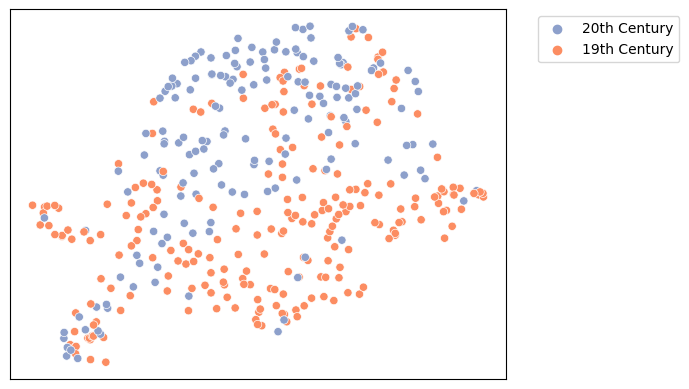

In [19]:
# Use the same function we created for plotting above
plot_umap_embeddings(poetry_umap_embeddings, poetry_labels, annotate_idxs=False)

The two categories are much more intermingled here than they were for narrative vs. non-narrative. It's much harder to identify 19th century vs 20th century poems from these embeddings.

We can also explore these poems by choosing a poem and examining which poems are most similar according to the embedding similarity, just like we did to examine the narrative outliers. Let's look at poem 0 and 100, chosen arbitrarily.

In [20]:
# Print a poem's title and author
def print_poem(df, idx):
  row = df.iloc[idx]
  print(f"{row['title']} by {row['author']} ({row['lifespan']}):")
  print(row['text'].replace('\r\n', ' '))
  print()

# Take as input the index of a poem, and print the nearest neighbors in the
# embedding space.
def print_closest_poems(poem_idx):
  # Get this poem's embedding
  poem_embedding = poetry_embeddings[poem_idx, :]
  # Get cosine similarities with all the other poem embeddings
  cosine_similarities = np.dot(poetry_embeddings, poem_embedding)
  # Sort the poems in descending order by similarity
  ordered_poem_idxs = np.argsort(cosine_similarities)[::-1]
  # A vector's cosine similarity with itself is always 1,
  # so it will be the most similar vector to itself
  assert(ordered_poem_idxs[0] == poem_idx)
  print_poem(poetry_df, poem_idx)
  for num, idx in enumerate(ordered_poem_idxs[1:4]):
    print(f'Nearest neighbor {num}: {poetry_labels[idx]}, {cosine_similarities[idx]:.4f} cosine similarity')
    print_poem(poetry_df, idx)

In [21]:
# Pick a poem, find closest poems
print_closest_poems(poem_idx=0)

Crowride by A. R. Ammons (February 18, 1926-February 25, 2001):
When the crow lands, the tip of the sprung spruce
 bough weighs so low, the system so friction-free,
 the bobbing lasts way past any interest in the subject.

Nearest neighbor 0: 20th Century, 0.8245 cosine similarity
Design by A. R. Ammons (February 18, 1926-February 25, 2001):
The drop seeps whole from boulder-lichen or ledge moss and drops,
 joining, to trickle, run, fall, dash, sprawl in held deeps,
 to rush shallows, spill thin through heights, but then, edging,
 to eddy aside, nothing of all but nothing's curl of motion spent.

Nearest neighbor 1: 20th Century, 0.7992 cosine similarity
Small Song by A. R. Ammons (February 18, 1926-February 25, 2001):
The reeds give way to the wind and give the wind away.

Nearest neighbor 2: 20th Century, 0.7946 cosine similarity
After Yesterday by A. R. Ammons (February 18, 1926-February 25, 2001):
After yesterday afternoon's blue clouds and white rain the mockingbird in the backyar

In [22]:
print_closest_poems(poem_idx=100)

The Rosary of My Tears by Abram Joseph Ryan (August 15, 1839 - April 22, 1886):
Some reckon their age by years,  Some measure their life by art; But some tell their days by the flow of their tears,  And their lives by the moans of their heart.
 The dials of earth may show  The length, not the depth, of years, Few or many they come, few or many they go,  But time is best measured by tears.
 Ah! not by the silver gray  That creeps thro' the sunny hair, And not by the scenes that we pass on our way,  And not by the furrows the fingers of care
 On forehead and face have made.  Not so do we count our years; Not by the sun of the earth, but the shade  Of our souls, and the fall of our tears.
 For the young are ofttimes old,  Though their brows be bright and fair; While their blood beats warm, their hearts are cold --  O'er them the spring -- but winter is there.
 And the old are ofttimes young,  When their hair is thin and white; And they sing in age, as in youth they sung,  And they laugh, 

For both of these poems, the other poems with the most similar embeddings are those by the same author! When representing poems with ST5 document embeddings, authorship accounts for large differences between embeddings. This does not mean that these embeddings are useless, but we have identified an important part of what embedding similarity recovers in this context.

These ST5 embeddings represent author well, while it is much harder to tell poems from different periods apart.